In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf 
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt 

In [3]:
IMAGE_SIZE = 896,896
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 90

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PalmLeavesDataset",
    shuffle=True,
    image_size =(IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1800 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Bug', 'Dubas', 'Healthy']

In [6]:
len(dataset)

57

In [7]:
57*32

1824

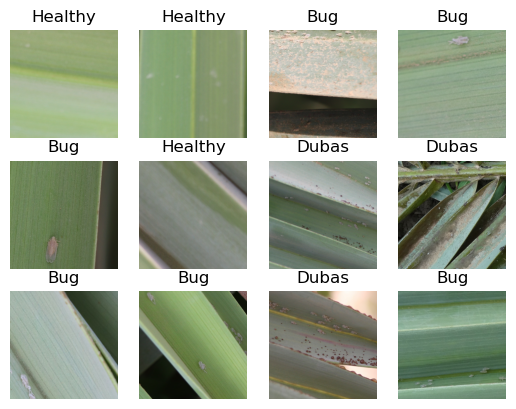

In [8]:
for image_batch, lable_batch in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lable_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partition_tf(ds, train_split=0.5, val_split=0.2, test_split=0.3, shuffle=True, shuffle_size = 10000 ):

    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(896,896),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
#BUILD CNN -- building the model
#Will have different layers for the model 

input_shape = (BATCH_SIZE, 896,896, CHANNELS ) # thats it our format for our input 

n_classes = 3 # number of classes is 3 


model= models.Sequential ([

    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax') #softmax activation function will  normalize the probility of my classes 

])

model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 896, 896, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 896, 896, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 894, 894, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 447, 447, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 445, 445, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 222, 222, 64)        0         
 g2D)                                                 

In [16]:
#COMPILE USING OPTIMIZER

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [17]:
#TRAIN MY NETWORK 

history = model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/90
28/28 [==============================] - 351s 12s/step - loss: 1.1121 - accuracy: 0.3348 - val_loss: 1.0950 - val_accuracy: 0.4096
Epoch 2/90
28/28 [==============================] - 348s 12s/step - loss: 1.0673 - accuracy: 0.3460 - val_loss: 1.0859 - val_accuracy: 0.4263
Epoch 3/90
28/28 [==============================] - 349s 12s/step - loss: 1.0857 - accuracy: 0.3795 - val_loss: 1.0713 - val_accuracy: 0.4051
Epoch 4/90
28/28 [==============================] - 362s 13s/step - loss: 1.0113 - accuracy: 0.4844 - val_loss: 1.0121 - val_accuracy: 0.4688
Epoch 5/90
28/28 [==============================] - 361s 13s/step - loss: 0.9782 - accuracy: 0.4978 - val_loss: 0.9175 - val_accuracy: 0.5525
Epoch 6/90
28/28 [==============================] - 375s 13s/step - loss: 0.9589 - accuracy: 0.5301 - val_loss: 0.9410 - val_accuracy: 0.5592
Epoch 7/90
28/28 [==============================] - 371s 13s/step - loss: 0.9226 - accuracy: 0.5670 - val_loss: 0.8639 - val_accuracy: 0.5848
Epoch 

In [18]:
#TEST THE MODEL 

scores = model.evaluate(test_ds)

28/28 [==============================] - 51s 2s/step - loss: 0.1584 - accuracy: 0.9397


In [19]:
scores

[0.15840184688568115, 0.9397321343421936]

In [20]:
history.history['accuracy']

[0.3348214328289032,
 0.3459821343421936,
 0.3794642984867096,
 0.484375,
 0.4977678656578064,
 0.5301339030265808,
 0.5669642686843872,
 0.6015625,
 0.5982142686843872,
 0.6127232313156128,
 0.6428571343421936,
 0.6819196343421936,
 0.6741071343421936,
 0.6808035969734192,
 0.7254464030265808,
 0.7555803656578064,
 0.8002232313156128,
 0.7790178656578064,
 0.7823660969734192,
 0.7946428656578064,
 0.8035714030265808,
 0.8258928656578064,
 0.8292410969734192,
 0.8537946343421936,
 0.8392857313156128,
 0.8671875,
 0.8694196343421936,
 0.8694196343421936,
 0.8415178656578064,
 0.875,
 0.8638392686843872,
 0.8683035969734192,
 0.8482142686843872,
 0.8470982313156128,
 0.8805803656578064,
 0.8850446343421936,
 0.90625,
 0.8928571343421936,
 0.8872767686843872,
 0.8895089030265808,
 0.8928571343421936,
 0.8683035969734192,
 0.9051339030265808,
 0.8850446343421936,
 0.8883928656578064,
 0.8883928656578064,
 0.9040178656578064,
 0.9174107313156128,
 0.9073660969734192,
 0.8995535969734192,
 0

In [21]:
# Will put them into variables 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

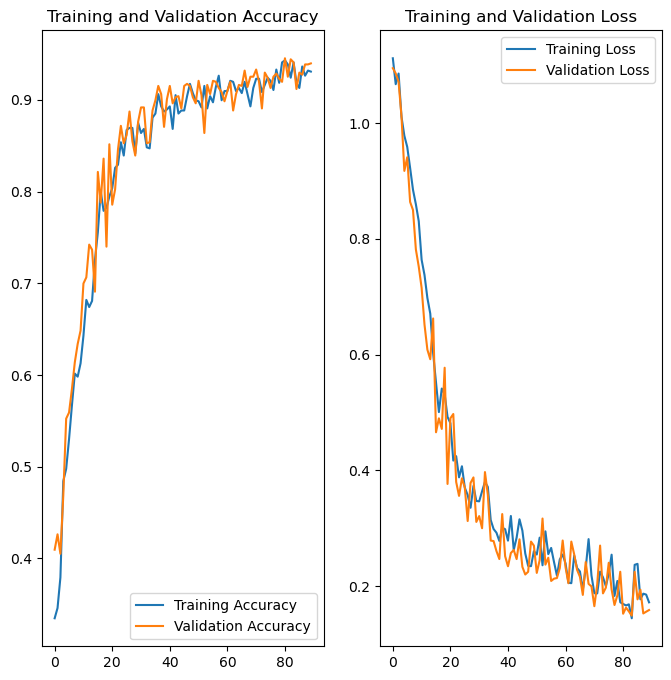

In [22]:
#PLOT TRAINING AND VALIDATION ACCURACY 

plt.figure (figsize =(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range (EPOCH), acc, label = 'Training Accuracy')
plt.plot(range (EPOCH), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title ('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range (EPOCH), loss, label = 'Training Loss')
plt.plot(range (EPOCH), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title ('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bug
1/1 [==============================] - 2s 2s/step
predected label: Bug


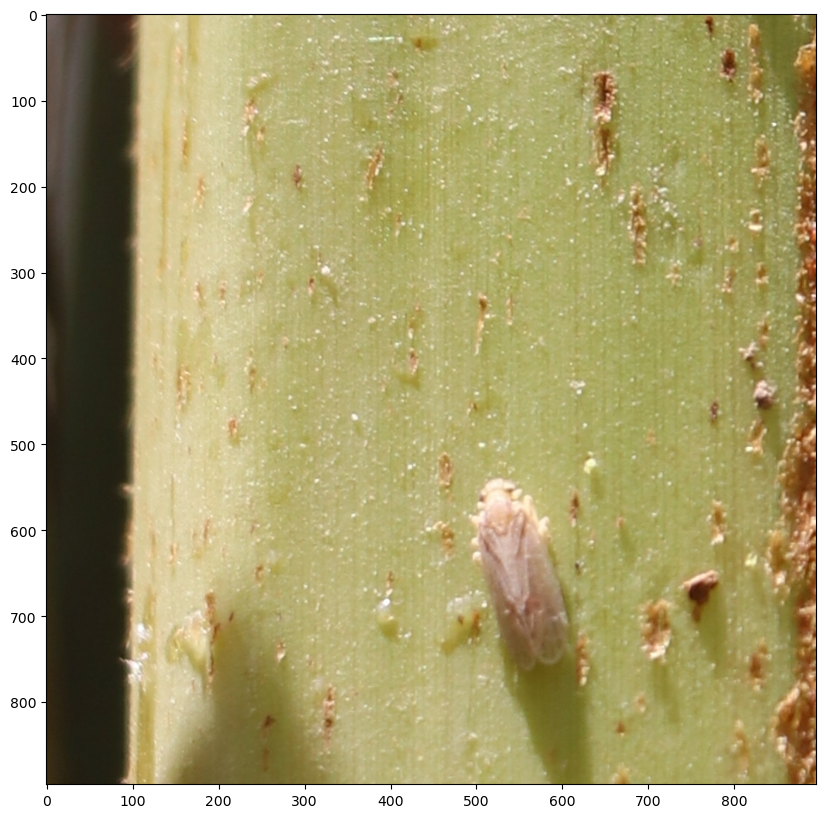

In [23]:
#PREDECTION
import numpy as np 
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0].numpy()
    
    print ("first image to predict")
    plt.imshow(first_image)
    print ("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predected label:", class_names[np.argmax(batch_prediction[0])])

In [24]:
#SIMPLE FUNCTION: TAKING MODEL AND IMAGE AS INPUT AND TELLING WHAT THE PREDICTED CLASS AND CONFIDENCE 

def predict (model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round (100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 93ms/step


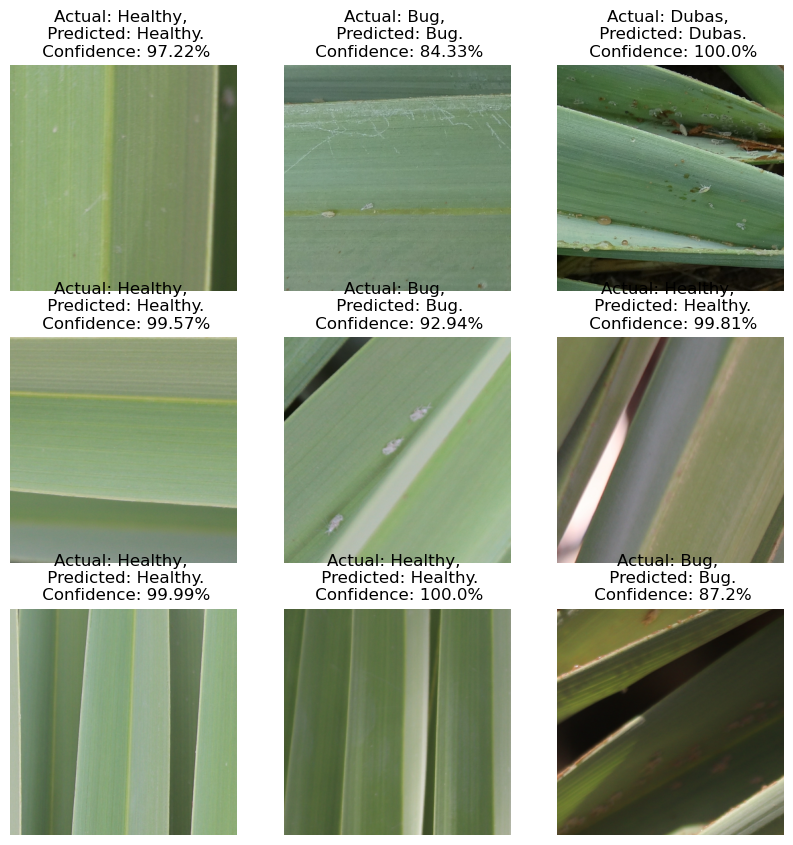

In [25]:
#RUN THE PREDICTION
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot (3, 3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title (f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [26]:
model_version=2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
